In [1]:
from networkx import grid_graph
import networkx as nx
import numpy as np
import random
from matplotlib import colors, cm
import matplotlib.pyplot as plt
#%matplotlib qt
from time import sleep
import matplotlib.animation as animation
from dendropy.calculate import treemeasure
from dendropy import Tree as DTree
from io import StringIO
from random import sample, random, choice
from copy import deepcopy
from math import log
from matplotlib.animation import PillowWriter
from ete3 import Tree, NodeStyle, TreeStyle
import tqdm
from Bio import Phylo
from plot_eteTree import plot_tree
from collections import Counter
import pandas as pd
from scipy.stats import poisson 
# Takes a genotype and converts it to an integer for use indexing the fitness landscape list 
def convertGenotypeToInt(genotype):
	out = 0
	for bit in genotype:
		out = (out << 1) | bit
	return out

# Converts an integer to a genotype by taking the binary value and padding to the left by 0s		
def convertIntToGenotype(anInt, pad):
	offset = 2**pad
	return [int(x) for x in bin(offset+anInt)[3:]]	

def flip(allele):
    if allele ==1:
        allele = 0
    else:
        allele =1
        
    return allele



In [239]:
def deathprob(d,m,k,p,s,pk):
    y = -(p-s)* ((d**k)/((d**k)- (s-p)/s))*((m - pk)/pk) + s
    return y


def mutation(r,dist):
    check = np.append(dist,r)
    check.sort()
    m = np.where(check ==r )[0][0]
    return m
    
def poisson_max_cdf(x,l,n):
    y = poisson.cdf(x,l)**n
    return y
    
    
def sort_pairs(pair):
    # Extract integer after "r".
    return int(pair[0][1:])
   
def make_tree_from_list(mut_pairs):
    parents = []
    children = []
    pairs_of_mutations = []
    for item in mut_pairs:
        a = 'r'+str(item[0])
        b = 'r'+str(item[1])
        pairs_of_mutations.append((a,b))
    t = Tree() # Creates an empty tree
    r0 = t.add_child(name="r0")
    lookup = {"r0": r0}

    for pair in sorted(pairs_of_mutations, key=sort_pairs):
        parentname = pair[0]
        childname = pair[1]
        if childname not in lookup:
            if parentname in lookup:
                newchild = lookup[parentname].add_child(name = childname)
                lookup.update({childname: newchild})

                parents.append(parentname) #make list of unique terminal nodes (no children of children)
                children.append(newchild)
            else:
                print(pair)
                raise RuntimeError('Must not happen.')

    return t

def make_pruned_tree_from_list(mut_pairs):
    parents = []
    children = []
    pairs_of_mutations = []
    for item in mut_pairs:
        a = 'r'+str(item[0])
        b = 'r'+str(item[1])
        pairs_of_mutations.append((a,b))
    t = Tree() # Creates an empty tree
    r0 = t.add_child(name="r0")
    lookup = {"r0": r0}
    prune_list = ['r0']
    for pair in sorted(pairs_of_mutations, key=sort_pairs):
        parentname = pair[0]
        childname = pair[1]
        if childname not in lookup:
            if parentname in lookup:
                newchild = lookup[parentname].add_child(name = childname)
                lookup.update({childname: newchild})
                if parentname not in parents:
                    prune_list.append(lookup[parentname])
                parents.append(parentname) #make list of unique terminal nodes (no children of children)
                children.append(newchild)
            else:
                print(pair)
                raise RuntimeError('Must not happen.')
    prune_count = Counter(children)
    t.prune(prune_list)
    return t


In [3]:
def sim_user_abx(wt,ln, g,ab, mut_rate,k, p,s,pk,birth_rate):
    
    width = wt
    length = ln
    grid_size = g
    
    ## bacteria per grid cell as mapped to MegaPLate
    bps = int(((60*((120/9)*5) * 10**8)/1)/(ln*wt))
    ##setup nx graph to find neibors quickly
    G = grid_graph(dim=[wt, ln])
    
    ##set up grid to keep track of cell state i.e. number of mutations
    cells = np.full((ln,wt),-1)
    cells[0] = 0 
    
    ##set up grid to keep track of cell state i.e. number of mutations
    muts = np.full((ln,wt),0)
    
    ##dstribution of for max of scamples drawn from poisson
    prob_dist = poisson_max_cdf([0,1,2,3,4,5,6],mut_rate,bps)

    
    
    
    ##set up grid that maps abx conc.  to space
    ab = ab
    
    #storing cells and mutation
    cell_history = []
    mut_pairs = []
    mut_ID = 0
    ##begin evolution
    while all(cells[-1] == -1) and len(cell_history) != 40002:
    #while all(cells[-1] == -1):
        
        ## save current state map to list
        cell_history.append(cells.tolist())
        
        
        ##find slots where there is a living cells
        cells_where =  np.where(cells != -1)
        
        
        ##create a randomized list of the living cells with which to iterate through
        cells_list = []
        for x, y in zip(cells_where[0], cells_where[1]):
            cells_list.append([x,y])
            
        np.random.shuffle(cells_list)
        
        ##decide if each living in this generation will die, live, or mutate
        for j in cells_list: 
            d_draw, b_draw  = [random(),random()]
            
            ##death
            if deathprob(ab[tuple(j)],cells[tuple(j)],k,p,s,pk) > d_draw:
                cells[tuple(j)] == -1
                #print('hi')
                
           
            else:   
            #birth
                if birth_rate > b_draw:
                
                    neighbors = [x for x in G.neighbors(tuple(j))]

                    #find which of the neighboring cells are empty, and divide, with a daughter cell in that space
                    empty = np.where(-1 == np.array([cells[tuple(x)] for x in neighbors]) )
                    if len(empty[0]) != 0:
                        pick = neighbors[choice(empty)[0]]
                        
                        #mutated daughter cells
                        m = mutation(random(),prob_dist)
                        if m != 0:
                            mut_ID = mut_ID +1
                            mut_pairs.append([muts[tuple(j)],mut_ID])
                            cells[tuple(j)] = cells[tuple(j)]+m
                            muts[tuple(j)] = mut_ID
                        #divide
                        cells[tuple(pick)] = cells[tuple(j)]


    return cell_history, mut_pairs,

# Megaplate Experiment

In [ ]:
##without mutation, i.e. time reflects time of bacterial 'swarm'
wd = 270
ln = 300
gr = 5

l = [val for sublist in [[j for i in range(int(ln/gr))] for j in range (0,gr)] for val in sublist]
ab =[[3*10**(i-1)]*wd for i  in l if i != 0]
[ab.insert(i, [0]*wd) for i in range(0,int(ln/gr))]
abx_grad = np.array(ab)


ch,mp = sim_user_abx(wt = wd,ln =ln,g= gr, ab = np.full((ln,wd),-1),mut_rate=0,k = .7, p = 1.0,s = .05, pk= 973,birth_rate = .95)

In [303]:

%%time 
ch1,mp = sim_user_abx(wt = wd,ln =ln,g= gr, ab = abx_grad,mut_rate=.0014,k = .4, p = 1.0, s = .1, pk= 971,birth_rate = .6)

CPU times: user 6min 15s, sys: 5.51 s, total: 6min 21s
Wall time: 6min 34s


In [306]:
print('approximate swarm:experiment : ' + str(300/len(ch1)),'maximum total mutations:' + str(np.array(ch1[-1]).max()))

approximate swarm:experiment: 0.5008347245409015 maximum total mutations:841


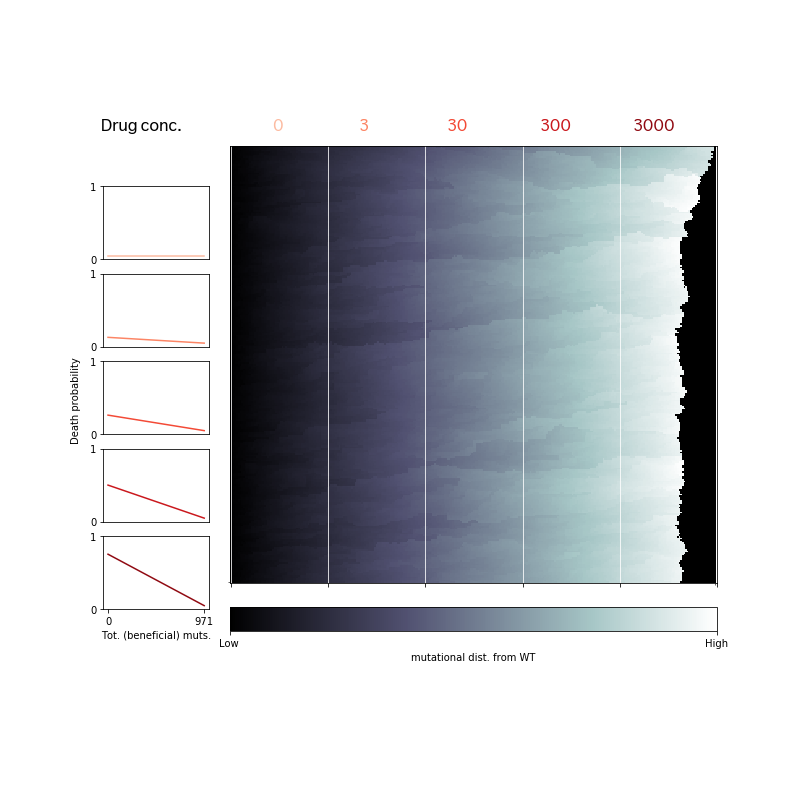

In [307]:
import matplotlib.gridspec as gridspec
fig =plt.figure(figsize=(11,11),constrained_layout=True)
gs1 =  gridspec.GridSpec(nrows=7, ncols=5)
ax1 = fig.add_subplot(gs1[:, 1:])

norm = colors.Normalize(vmin = 0 ,vmax=np.array(ch1[-1]).max())
red = plt.get_cmap('Reds')

cNorm  = colors.Normalize(vmin=0, vmax=12)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=red)

sub_axs = []
for i in range(gr):
    #sub_axs.append(fig.add_subplot(gs1[i +1, 0]))
    ax = fig.add_subplot(gs1[i+1 , 0])
    ax.set_yticks([0,1])
    plt.ylim(bottom=0,top=1)
    ax.set_xticks([])
    ax.plot(np.linspace(0,971,972),
            deathprob(np.unique(abx_grad)[i],
                      np.linspace(0,971,972),.5,1,.05,971),color = scalarMap.to_rgba(2*i+3))
    if i == gr - 1:
        ax.set_xticks([0,971])
        ax.set_xlabel('Tot. (beneficial) muts.')
    
    
    
hi = ax1.imshow(np.array(ch1[-1]).T, cmap='bone',norm = norm)


ax1.annotate('Drug conc.', xy=(70, 1), xytext=(-80, -10),fontsize=16, fontname = 'Sathu')

for i in range(len(np.unique(abx_grad))):
    
    ax1.annotate('%d' % np.unique(abx_grad)[i], xy=(70, 1), 
                 xytext=(48+ 25 * log(.4+np.unique(abx_grad)[i]), -10),
                 fontsize=16,fontname = 'Sathu',color = scalarMap.to_rgba(2*i+3))

    
cbar = fig.colorbar(hi,ax=ax1, orientation = 'horizontal',pad = .04)
cbar.set_ticks([0,np.array(ch1).max()])
cbar.set_ticklabels(["Low ",'High'])
cbar.set_label("mutational dist. from WT")

#ax1.axis('off')
ax1.set_xticklabels([])
ax1.set_xticks([299], minor=True)
ax1.set_yticks([269], minor=True)
ax1.set_xticks([i*60 for i in range(0,gr+1)])
ax1.set_yticks([])
ax1.grid(b=True, which = 'major',color='w')


shadowaxes = fig.add_subplot(111, xticks=[], yticks=[], frame_on=False)
shadowaxes.set_ylabel('Death probability', labelpad = -70)



plt.savefig('grid_diagram.eps', format='eps', dpi=1000)

As in Baym et al. Bacteria, evolve accross a large 'petri dish', in which there are rectangular zones of increasing antibiotic concentration. Each grid cell corresponds to many (i.e. millions of) bacteria. Every iteration cells may die, divide, and mutation with a given probability, determined stochastically. 

Modeled mutations are actively 'beneficial' as each mutation confers a fitness benefit - there is a linear relationship between death probability and the number of mutations a cell has. The slope of this relationship is deterimened by a pharmacodynamical model describing the relationship between fitness and drug concentration as in Regoes et al. With each generation the number of mutations a cell aquires following death is as follows: it is assumed that within all the bacteria represented by a grid cell the bacteria with the most mutations is the most fit and will outocmpete the less mutated bacteria. Hence the number of mutations is modeled as cumulative probability distribution of the maximum expected value of mutations for a sample of mutations drawn out of a poisson distriution. The size of this smaple corresponds to the amount cells in the MegaPlate that correspond to a simulation grid cell.

Taken together, the variables in this model include a constant birth rate and parameters of pharmacodyanamic model (hill coefficient, parameter describing death rate in absence of drugs, and parameter describing maximum fitness reduction due to drug). 

Here-in we demonstrate parameter sweeps with goal of estimating the mutation rate for the most highly mutable bacterial sub-clones in the experiment. Our potential estimate is contratined by the total time for the bacteria to fill the plate, the total mutations observed, and assumed maximum possible fitness reduction due to drug of 100%. 


# Parameter sweep

Here we coarsely sweep through parameters of the system to coarsely identify model parameters that correspond to  system constraints stated above. The result of this analysis will then allow for a finer parameter to estimate mutation rate

In [ ]:
mut_rate = [.00009,.0002,.0005,.0008,.001,.0012]
wd = 270
ln = 300
gr = 5



l = [val for sublist in [[j for i in range(int(ln/gr))] for j in range (0,gr)] for val in sublist]
ab =[[3*10**(i-1)]*wd for i  in l if i != 0]
[ab.insert(i, [0]*wd) for i in range(0,int(ln/gr))]
abx_grad = np.array(ab)


k = [1,2,5,7]
p= 1
s = [.01,.05,.07]
pk = 971
birth_rate = .95 

reps = 1
dicts_MegaPlate_coarse_971 = []
    
for a in range(reps):
    for b in range(len(mut_rate)):
        for c in range(len(k)):
            for d in tqdm.tqdm(range(len(s))):
                #for e in tqdm.tqdm(range(len(pk))):
                



                cellhistory,mut_pairs =sim_user_abx(wt = wd,ln = ln, g = gr,ab = abx_grad, 
                                                    mut_rate= mut_rate[b],k = k[c], s = s[d],
                                                    p = p, pk=pk,birth_rate = birth_rate)
                t = make_tree_from_list(mut_pairs)
                treePass = t.write(format = 1)
                DendroTree = DTree.get(data = treePass, schema = 'newick')
                size = (len([i for i in t.get_leaves()]))
                time = (len(cellhistory))
                muts = np.array(cellhistory).max()
                b1 = treemeasure.B1(DendroTree)
                n_bar = treemeasure.N_bar(DendroTree)
                sackin = (treemeasure.sackin_index(DendroTree, normalize = 'yule'))
                dicts_MegaPlate_coarse_971.append({"mut_rate":mut_rate[b],"k":k[c],'s':s[d],"pk":pk,"size":size,"time":time,"muts":muts,
                          "n_bar":n_bar,"sackin":sackin})




100%|██████████| 3/3 [26:05<00:00, 521.96s/it]

100%|██████████| 3/3 [30:14<00:00, 604.99s/it]

100%|██████████| 3/3 [30:05<00:00, 601.71s/it]

100%|██████████| 3/3 [34:36<00:00, 692.13s/it]

100%|██████████| 3/3 [25:19<00:00, 506.54s/it]

100%|██████████| 3/3 [27:09<00:00, 543.13s/it]

100%|██████████| 3/3 [29:00<00:00, 580.01s/it]

100%|██████████| 3/3 [30:49<00:00, 616.46s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

In [764]:
import shelve


# file to be used
shelf = shelve.open("dicts_MegaPlate_coarse_971.shlf")

# serializing
shelf["my_dict"] = dicts_MegaPlate_coarse_971

shelf.close()

In [7]:
import shelve

shelf = shelve.open("dicts_MegaPlate_coarse_971.shlf") # the same filename that you used before, please
dicts_MegaPlate_coarse_971= shelf["my_dict"]
shelf.close()

In [8]:
e_coli_swarmv = 40
MEGAplatesize = (120/9)*5
mp_swarm_time = MEGAplatesize*10**4/(e_coli_swarmv*3600)
mp_exp_time = 264
mp_swarm_time/mp_exp_time

0.017536475869809203

In [13]:
df_971 =  pd.DataFrame(dicts_MegaPlate_coarse_971)

df_971['time_ratio']= 200/df_971['time']
#df_971 = df_971[df_971['time_ratio'] < .02]
df_971 = df_971[df_971['muts'] > 200]



In [14]:
df_971.sort_values(by='muts')

,k,mut_rate,muts,n_bar,pk,s,sackin,size,time,time_ratio
0,1,0.00009,399,2.164926,971,0.01,-19.180094,65860,493,0.405680
12,1,0.00020,442,2.163202,971,0.01,-19.200437,66476,486,0.411523
1,1,0.00009,454,2.211054,971,0.05,-19.096199,64628,651,0.307220
3,2,0.00009,454,2.203600,971,0.01,-19.113315,64941,707,0.282885
6,5,0.00009,460,2.236488,971,0.01,-18.965617,61318,807,0.247831
2,1,0.00009,462,2.223312,971,0.07,-19.055014,63700,701,0.285307
16,2,0.00020,478,2.228957,971,0.05,-18.898821,59081,749,0.267023
5,2,0.00009,481,2.247286,971,0.07,-18.982450,62171,912,0.219298
4,2,0.00009,483,2.233157,971,0.05,-19.014353,62726,855,0.233918
15,2,0.00020,486,2.199136,971,0.01,-19.100210,64373,666,0.300300


In [789]:
df_971.sort_values(by='time');

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


TypeError: Empty 'DataFrame': no numeric data to plot

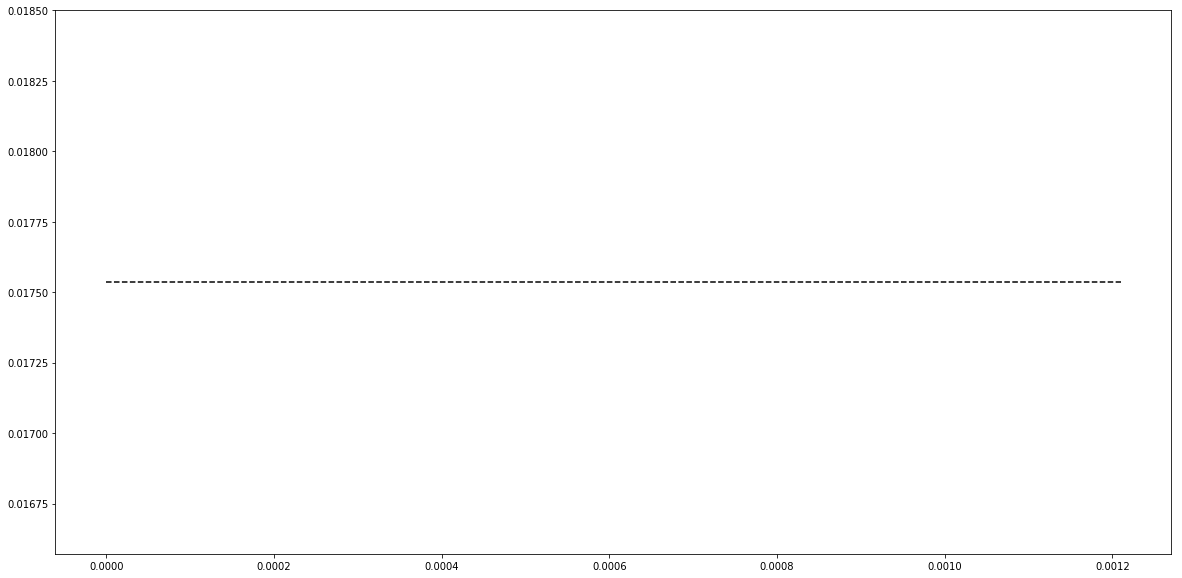

In [790]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize =(20,10))

ax.hlines(mp_swarm_time/mp_exp_time,0, max(df_971['mut_rate'])*1.1,label = 'Experimental time from MegaPlate',linestyles = 'dashed')
        
for i in k:
    for j in s :
        df_971[df_971['k']==i][df_971['s']==j].plot('mut_rate','time_ratio',ax=ax,label=('k = {0}, s = .5, n1 =4, mh = {1}'.format(i,j)))

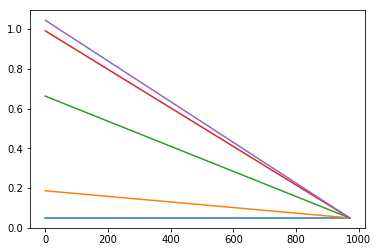

In [223]:
for i in [0,3,30,300,3000]:
    plt.plot(t,deathprob(i,t,1,1,.05,971))

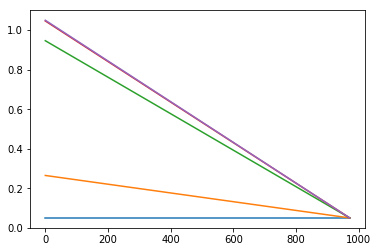

In [224]:
for i in [0,3,30,300,3000]:
    plt.plot(t,deathprob(i,t,1.5,1,.05,971))

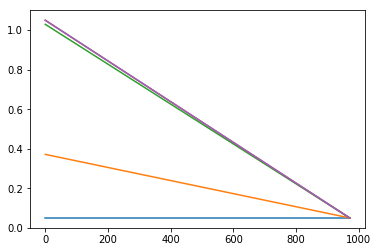

In [225]:
for i in [0,3,30,300,3000]:
    plt.plot(t,deathprob(i,t,2,1,.05,971))

In [236]:
def deathprob(d,m,k,p,s,pk):
    y = -(p-s) * ((d**k)/((d**k)- (s-p)/s))*((m - pk)/pk) +s
    return y

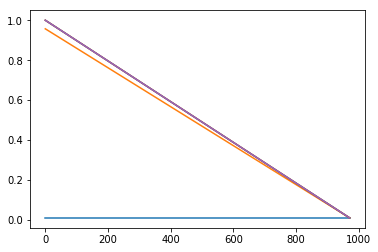

In [241]:
for i in [0,3,30,300,3000]:
    plt.plot(t,deathprob(i,t,7,1,.01,971))

In [238]:
deathprob(0,0,2,1,.05,971)

0.05